In [ ]:
import pandas as pd
import numpy as np

import holidays

import pickle
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 변수 생성

root_path = '/content/drive/MyDrive/AIVLE/공모전/기상청 빅데이터 콘테스트'    # 본인 데이터 경로 작성

In [ ]:
with open(root_path + '/rf_models.pkl', 'rb') as f:
    rf_models = pickle.load(f)

with open(root_path + '/rf_scalers.pkl', 'rb') as f:
    rf_scalers = pickle.load(f)

In [ ]:
# 기상특보 발표기준에 따른 칼럼 추가

def weather_report(train_df):
    # 한파
    train_df['ta_chi_cold_caution'] = (train_df['ta_chi'] <= -12) & (train_df['ta_chi'] > -15)
    train_df['ta_chi_cold_alert'] = train_df['ta_chi'] <= -15

    # 폭염
    train_df['ta_chi_hot_caution'] = (train_df['ta_chi'] >= 33) & (train_df['ta_chi'] < 35)
    train_df['ta_chi_hot_alert'] = train_df['ta_chi'] >= 35

    # 풍속
    train_df['ws_caution'] = (train_df['ws'] >= 14) & (train_df['ws'] < 21)
    train_df['ws_alert'] = (train_df['ws'] >= 21)

    # 호우
    train_df['rn_hr3_caution'] = (train_df['rn_hr1']) >= 20
    train_df['rn_hr3_alert'] = (train_df['rn_hr1']) >= 30

    # 비오는 날, 현재 비오는 시간 체크
    train_df['rainy_day'] = train_df['rn_day'] > 0
    train_df['raining'] = train_df['rn_hr1'] > 0

    return train_df

In [ ]:
# 지하철 방향 더미화

def direction(train_df):
    train_df['direction'] = pd.Categorical(train_df['Direction'], categories=['내선', '외선', '상선', '하선'])
    train_dummies = pd.get_dummies(train_df[['direction']])

    train_df = pd.concat([train_df, train_dummies], axis=1)
    return train_df

In [ ]:
# 휴일 컬럼 추가

def off_day(train_df):
    kr_holidays = holidays.KR()

    def check_holidays(row):
        d = date(row['year'], row['month'], row['day'])
        return d in kr_holidays

    def check_weekend(row):
        d = date(row['year'], row['month'], row['day'])
        return d.weekday() >= 5

    train_df['is_holiday'] = train_df.apply(check_holidays, axis=1)
    train_df['is_weekend'] = train_df.apply(check_weekend, axis=1)

    return train_df

In [ ]:
# 코로나 거리두기 단계 위험도 가중치

def corona(train_df):
    train_df['corona_level'] = 0  # 기본값 설정

    train_df.loc[(train_df['tm'] >= 2020120800) & (train_df['tm'] < 2021021500), 'corona_level'] = 5
    train_df.loc[(train_df['tm'] >= 2021021500) & (train_df['tm'] < 2021071200), 'corona_level'] = 4
    train_df.loc[(train_df['tm'] >= 2021071200) & (train_df['tm'] < 2021110100), 'corona_level'] = 5
    train_df.loc[(train_df['tm'] >= 2021110100) & (train_df['tm'] < 2021121800), 'corona_level'] = 2
    train_df.loc[(train_df['tm'] >= 2021121800) & (train_df['tm'] < 2022041800), 'corona_level'] = 4
    train_df.loc[(train_df['tm'] >= 2022041800) & (train_df['tm'] < 2023032100), 'corona_level'] = 1    # 실내 마스크 의무 해제

    return train_df

In [ ]:
def get_df_pp(df):
    df['tm'] = df['TM'].astype(str)
    df.insert(0, 'year', df['tm'].str[:4].astype(int))
    df.insert(1, 'month', df['tm'].str[4:6].astype(int))
    df.insert(2, 'day', df['tm'].str[6:8].astype(int))
    df.insert(3, 'hour', df['tm'].str[8:10].astype(int))
    df['tm'] = df['tm'].astype(int)

    df['ta'] = df['TA'].replace(-99.0, np.nan)
    df['wd'] = df['WD'].mask(df['WD'] < 0, np.nan)
    df['ws'] = df['WS'].replace(-99.0, np.nan)
    df['rn_day'] = df['RN_DAY'].replace(-99.0, np.nan)
    df['rn_hr1'] = df['RN_HR1'].replace(-99.0, np.nan)
    df['hm'] = df['HM'].replace(-99.0, np.nan)
    df['ta_chi'] = df['ta_chi'].replace(-99.0, np.nan)
    df['si'] = df['SI']
    df.loc[df['hour'].isin([0, 1, 5, 21, 22, 23]), 'si'] = 0
    df.loc[(df['hour'].isin([6, 20])) & (df['si'] == -99.0), 'si'] = 0
    df['si'] = df['SI'].replace(-99.0, np.nan)
    df['line'] = df['Line'].astype(int)

    df = direction(df)
    df = off_day(df)
    df = weather_report(df)
    df = corona(df)

    return df

In [ ]:
use_columns = (['hour'] +
               ['ta_chi', 'ta_chi_cold_caution', 'ta_chi_cold_alert', 'ta_chi_hot_caution', 'ta_chi_hot_alert'] +
               ['ws_caution', 'ws_alert', 'rn_hr3_caution', 'rn_hr3_alert'] +
               ['rainy_day', 'raining'] +
               ['is_holiday', 'is_weekend'] +
               ['corona_level'] +
               ['direction_내선', 'direction_외선', 'direction_상선', 'direction_하선'])
target_column = ['Congestion']

def get_result_df(df):
    station_numbers = df['station_number'].unique()

    # station_number 기준으로 나누기
    groups = {station: df_group for station, df_group in df.groupby('station_number')}

    for idx, station_number in enumerate(station_numbers):
        print(idx + 1, '/', len(station_numbers), ':', station_number)
        group_df = groups[station_number]

        X = group_df[use_columns]

        if station_number == 1949:
            # 오류 데이터
            group_df[target_column] = 0.0
            continue

        if station_number in [2805, 2806, 2807, 2808, 2809, 2810]:
            # 가장 가까운 노선의 번호, 가까운 노선일수록 비슷한 데이터 양상을 띈다.
            station_number = 2811

        model = rf_models[str(station_number)]
        scaler = rf_scalers[str(station_number)]

        X_scaled = scaler.transform(X)
        y_pred = model.predict(X_scaled)
        y_pred = np.clip(y_pred, 0, None)

        group_df[target_column] = np.round(y_pred).astype(int).reshape(-1, 1)

    # 나중에 다시 합치기 (인덱스 유지)
    df_merged = pd.concat(groups.values()).sort_index()

    return df_merged

In [ ]:
test = pd.read_csv(root_path + '/test_subway.csv', encoding="cp949")

In [ ]:
df_pp = get_df_pp(test.copy())

In [ ]:
result_df = get_result_df(df_pp.copy())

1 / 370 : 150
2 / 370 : 151
3 / 370 : 152
4 / 370 : 153
5 / 370 : 154
6 / 370 : 155
7 / 370 : 156
8 / 370 : 157
9 / 370 : 158
10 / 370 : 159
11 / 370 : 1002
12 / 370 : 1003
13 / 370 : 1004
14 / 370 : 1005
15 / 370 : 1006
16 / 370 : 1007
17 / 370 : 1015
18 / 370 : 1016
19 / 370 : 1017
20 / 370 : 1018
21 / 370 : 1019
22 / 370 : 1020
23 / 370 : 1021
24 / 370 : 1022
25 / 370 : 1032
26 / 370 : 1701
27 / 370 : 1801
28 / 370 : 1802
29 / 370 : 1803
30 / 370 : 1804
31 / 370 : 1805
32 / 370 : 1806
33 / 370 : 1807
34 / 370 : 1808
35 / 370 : 1809
36 / 370 : 1810
37 / 370 : 1811
38 / 370 : 1812
39 / 370 : 1813
40 / 370 : 1814
41 / 370 : 1815
42 / 370 : 1816
43 / 370 : 1817
44 / 370 : 1821
45 / 370 : 1822
46 / 370 : 1823
47 / 370 : 1901
48 / 370 : 1902
49 / 370 : 1903
50 / 370 : 1904
51 / 370 : 1905
52 / 370 : 1906
53 / 370 : 1907
54 / 370 : 1908
55 / 370 : 1909
56 / 370 : 1910
57 / 370 : 1911
58 / 370 : 1912
59 / 370 : 1913
60 / 370 : 1914
61 / 370 : 1915
62 / 370 : 1916
63 / 370 : 1917
64 / 370 : 

In [ ]:
test.head()

,TM,Line,station_number,station_name,Direction,STN,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,Congestion
0,2024010100,1,150,서울역,상선,419,0.6,161.4,2.7,4.5,0.0,99.0,-99.0,-0.3,NaN
1,2024010101,1,150,서울역,상선,419,0.0,145.7,3.8,0.0,0.0,99.4,-99.0,-2.2,NaN
2,2024010102,1,150,서울역,상선,419,0.3,171.3,3.1,0.0,0.0,99.6,-99.0,-2.3,NaN
3,2024010105,1,150,서울역,상선,419,-0.1,176.0,3.0,0.0,0.0,98.1,-99.0,-0.1,NaN
4,2024010106,1,150,서울역,상선,419,-0.6,174.4,3.9,0.0,0.0,99.0,-99.0,0.0,NaN


In [ ]:
pp_columns = (['year', 'month', 'day', 'hour', 'tm', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'direction'] +
              ['ta_chi_cold_caution', 'ta_chi_cold_alert', 'ta_chi_hot_caution', 'ta_chi_hot_alert'] +
              ['ws_caution', 'ws_alert', 'rn_hr3_caution', 'rn_hr3_alert'] +
              ['rainy_day', 'raining'] +
              ['is_holiday', 'is_weekend'] +
              ['corona_level'] +
              ['line'] +
              ['direction_내선', 'direction_외선', 'direction_상선', 'direction_하선'])
result_df_pp = result_df.drop(columns=pp_columns, axis=1)

In [ ]:
result_df_pp.head()

,TM,Line,station_number,station_name,Direction,STN,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,Congestion
0,2024010100,1,150,서울역,상선,419,0.6,161.4,2.7,4.5,0.0,99.0,-99.0,-0.3,11
1,2024010101,1,150,서울역,상선,419,0.0,145.7,3.8,0.0,0.0,99.4,-99.0,-2.2,0
2,2024010102,1,150,서울역,상선,419,0.3,171.3,3.1,0.0,0.0,99.6,-99.0,-2.3,0
3,2024010105,1,150,서울역,상선,419,-0.1,176.0,3.0,0.0,0.0,98.1,-99.0,-0.1,2
4,2024010106,1,150,서울역,상선,419,-0.6,174.4,3.9,0.0,0.0,99.0,-99.0,0.0,4


In [ ]:
result_df_pp.to_csv(root_path + '/250551.csv', encoding="cp949", index=False)

<Axes: >

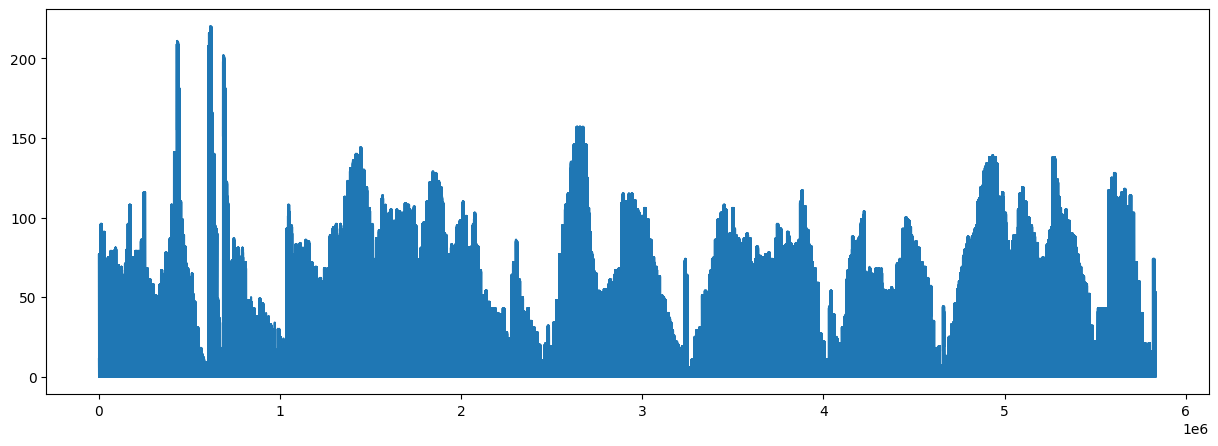

In [ ]:
result_df_pp['Congestion'].plot(figsize=(15, 5))